In [1]:
from scipy.stats import bootstrap
from hierarchy import *
from benlib.plot import scatter_cc, scatter_cc_multi, remove_frames
set_publication_figure_defaults()
fig_num = 2

clusters = Clusters(12)
clusters.summarize()
clusters.mark_excluded_units()

NR <= 200:
Anaesthetised: ic: 178, mgb:  84, mgbm:   0, ac: 298, total:  560
Awake:         ic: 262, mgb: 278, mgbm:   0, ac: 341, total:  881
Total:         ic: 440, mgb: 362, mgbm:   0, ac: 639, total: 1441

NR > 200:
Anaesthetised: ic:   7, mgb:  27, mgbm:   0, ac:  55, total:   89
Awake:         ic:   1, mgb:  29, mgbm:   0, ac:   1, total:   31
Total:         ic:   8, mgb:  56, mgbm:   0, ac:  56, total:  120

Loading "coch kernels; 16 folds; ElNet"
Fieldname: coch_kernel_main
Found single data file with 1561 clusters
All results present (1561 clusters)

Loading "main elnet a2a kernels (NR=200; all units; all valid data; 1 fold)"
Fieldname: a2a_kernels_main
/Users/ben/projects/michael-data/hierarchy/results/stim-12/a2a_kernels--state=anaesthetised-awake--subset=valid20-all--combo_lens=1-2-3--n_h=8--n_fut=5--k_folds=16--fold_idxes_to_include=15--noiseratio=200--regress=ElNet
Found data files with 1441 clusters
All results present (1441 clusters)

Loading "coch kernels; 16 folds; El

In [2]:
clusters.load_analyses(['coch_kernel_main', 'a2a_kernels_main',
                        'coch_kernel_sigmoid_main', 'a2a_kernels_sigmoid_main'])

Loading "coch kernels; 16 folds; ElNet"
Fieldname: coch_kernel_main
Found single data file with 1561 clusters
All results present (1561 clusters)

Loading "main elnet a2a kernels (NR=200; all units; all valid data; 1 fold)"
Fieldname: a2a_kernels_main
/Users/ben/projects/michael-data/hierarchy/results/stim-12/a2a_kernels--state=anaesthetised-awake--subset=valid20-all--combo_lens=1-2-3--n_h=8--n_fut=5--k_folds=16--fold_idxes_to_include=15--noiseratio=200--regress=ElNet
Found data files with 1441 clusters
All results present (1441 clusters)

Loading "coch kernels; 16 folds; ElNet; LN (sigmoid)"
Fieldname: coch_kernel_sigmoid_main
Found single data file with 1561 clusters
All results present (1561 clusters)

Loading "a2a kernels; 1 fold; ElNet; LN (sigmoid)"
Fieldname: a2a_kernels_sigmoid_main
Found single data file with 1441 clusters
** Missing more than 15 results **



In [3]:
def coch_kernel_main_ln_cc_norm_test(cluster, regressor_area=None):
    return cluster['coch_kernel_sigmoid_main']['sigmoid_fits'][-1]['sigmoid']['cc_norm_test'][0]

def a2a_kernels_main_ln_cc_norm_test(cluster, regressor_area):
    return cluster['a2a_kernels_sigmoid_main']['sigmoid_fits'][regressor_area][0]['sigmoid']['cc_norm_test'][0]

def get_valid_idx_unused(data):
    lens = [len(d) for d in data]
    if any([l!=lens[0] for l in lens]):
        raise ValueError('Data sets are different lengths')
    invalid_idx = set()
    for d in data:
        invalid_idx.update(set(np.where(np.isnan(d))[0]))
    valid_idx = range(len(data[0]))
    return [v for v in valid_idx if v not in invalid_idx]

n=616


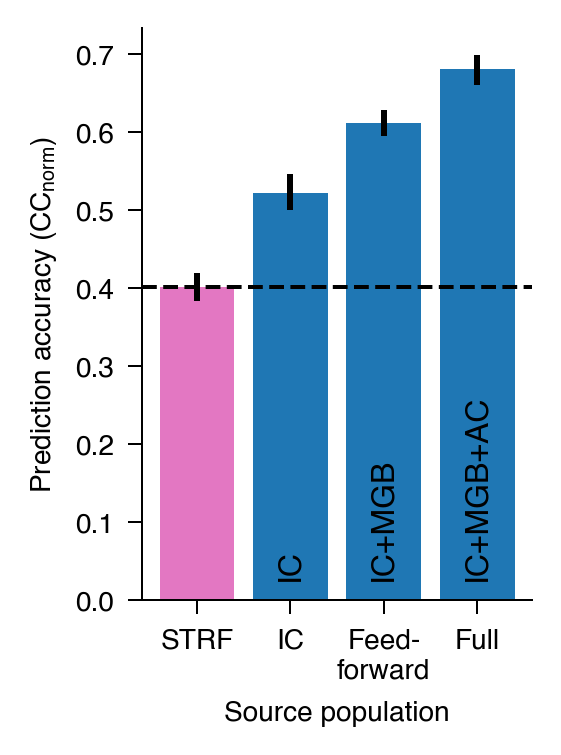

In [4]:
# median values for bar plot -- using LN model / sigmoid fits

plt.figure(figsize=(1.75, 2.58))

sel = clusters.select_data(brain_area='ac', noiseratio=200, excluded=False)
print('n=%d' % len(sel))

cc_norm_coch = [coch_kernel_main_ln_cc_norm_test(cl, None) for cl in sel]
cc_norm_ic = [a2a_kernels_main_ln_cc_norm_test(cl, 'ic') for cl in sel]
cc_norm_feedforward = [a2a_kernels_main_ln_cc_norm_test(cl, 'ic_mgb') for cl in sel]
cc_norm_full = [a2a_kernels_main_ln_cc_norm_test(cl, 'ic_mgb_ac') for cl in sel]

data = [cc_norm_coch, cc_norm_ic, cc_norm_feedforward, cc_norm_full]
labels = [r'STRF', r'IC', 'Feed-\nforward', r'Full']

# valid_idx = get_valid_idx(data)

mdn = [np.median(d) for d in data]
ci = [bootstrap((d,), np.median) for d in data]
err = [(m-c.confidence_interval.low, c.confidence_interval.high-m) for m,c in zip(mdn,ci)]
err_stack = np.vstack(err).T

plt.bar(range(len(data)),
        mdn,
        yerr=err_stack,
        color=['tab:pink', BRAIN_AREA_COLORS['ac'],
               BRAIN_AREA_COLORS['ac'], BRAIN_AREA_COLORS['ac']],
        capsize=0, error_kw={'elinewidth': 1.5})

plt.axhline(mdn[0], color='k', linestyle='--', lw=1)
plt.xticks(range(len(data)), labels)

plt.xlabel('Source population')
plt.ylabel('Prediction accuracy ($CC_{norm}$)')

remove_frames()

plt.text(1,0.025,'IC', horizontalalignment='center', verticalalignment='bottom', rotation = 90, size=8)
plt.text(2,0.025,'IC+MGB', horizontalalignment='center', verticalalignment='bottom', rotation = 90, size=8)
plt.text(3,0.025,'IC+MGB+AC', horizontalalignment='center', verticalalignment='bottom', rotation = 90, size=8)

plt.savefig('figure-%d-bar.pdf' % fig_num, bbox_inches="tight")

In [5]:
# %age improvement over cochleagram
100*(mdn/mdn[0]-1)

array([ 0.        , 29.93712874, 52.33491364, 69.44563432])

n=616


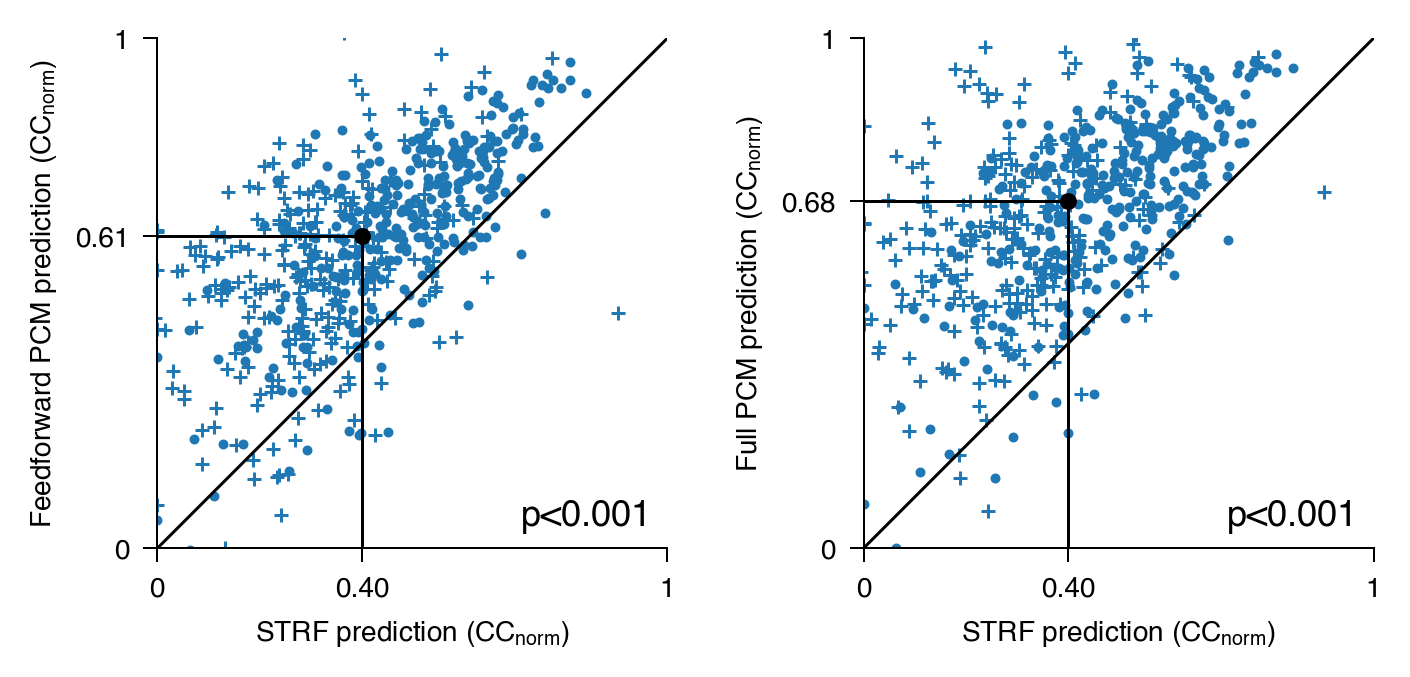

In [6]:
# Feedforward model vs cochleagram -- with awake vs anaesthetised symbols
# awake is dot, anesthetised is + 

# cm = 1/2.54  # centimeters in inches
# plt.subplots(figsize=(12*cm, 7*cm))

fig = plt.figure(figsize=(5.8,2.3))

awake = clusters.select_data(brain_area='ac', noiseratio=200, state='awake', excluded=False)
anaesthetised = clusters.select_data(brain_area='ac', noiseratio=200, state='anaesthetised', excluded=False)

# feedforward model vs cochleagram
plt.subplot(1,2,1)
regressor_area = 'ic_mgb'
x_data = [[coch_kernel_main_ln_cc_norm_test(cl, regressor_area) for cl in awake],
          [coch_kernel_main_ln_cc_norm_test(cl, regressor_area) for cl in anaesthetised]]
y_data = [[a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in awake],
          [a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in anaesthetised]]

scatter_cc_multi(x_data, y_data, colors=BRAIN_AREA_COLORS['ac'],
           p_value=True,
           accept_nans=False)

plt.xlabel('STRF prediction ($CC_{norm}$)')
plt.ylabel('Feedforward PCM prediction ($CC_{norm}$)')

# full model vs cochleagram
plt.subplot(1,2,2)
regressor_area = 'ic_mgb_ac'
x_data = [[coch_kernel_main_ln_cc_norm_test(cl, regressor_area) for cl in awake],
          [coch_kernel_main_ln_cc_norm_test(cl, regressor_area) for cl in anaesthetised]]
y_data = [[a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in awake],
          [a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in anaesthetised]]
scatter_cc_multi(x_data, y_data, colors=BRAIN_AREA_COLORS['ac'],
           p_value=True,
           accept_nans=False)

plt.xlabel('STRF prediction ($CC_{norm}$)')
plt.ylabel('Full PCM prediction ($CC_{norm}$)')

remove_frames(fig)

print('n=%d' % len(sel))

plt.savefig('figure-%d-scatter.pdf' % fig_num)

In [7]:
# statistics for panel e y-axis vs panel f y-axis
# full PC model vs feedforward PC model performance in predicting AC


all_data = clusters.select_data(brain_area='ac', noiseratio=200, state='awake', excluded=False)

regressor_area = 'ic_mgb'
y_data1 = [a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in all_data]

regressor_area = 'ic_mgb_ac'
y_data2 = [a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in all_data]

# y_data2.shape
wilcoxon(y_data1, y_data2)

WilcoxonResult(statistic=2686.0, pvalue=2.6158191346886474e-46)

n=616


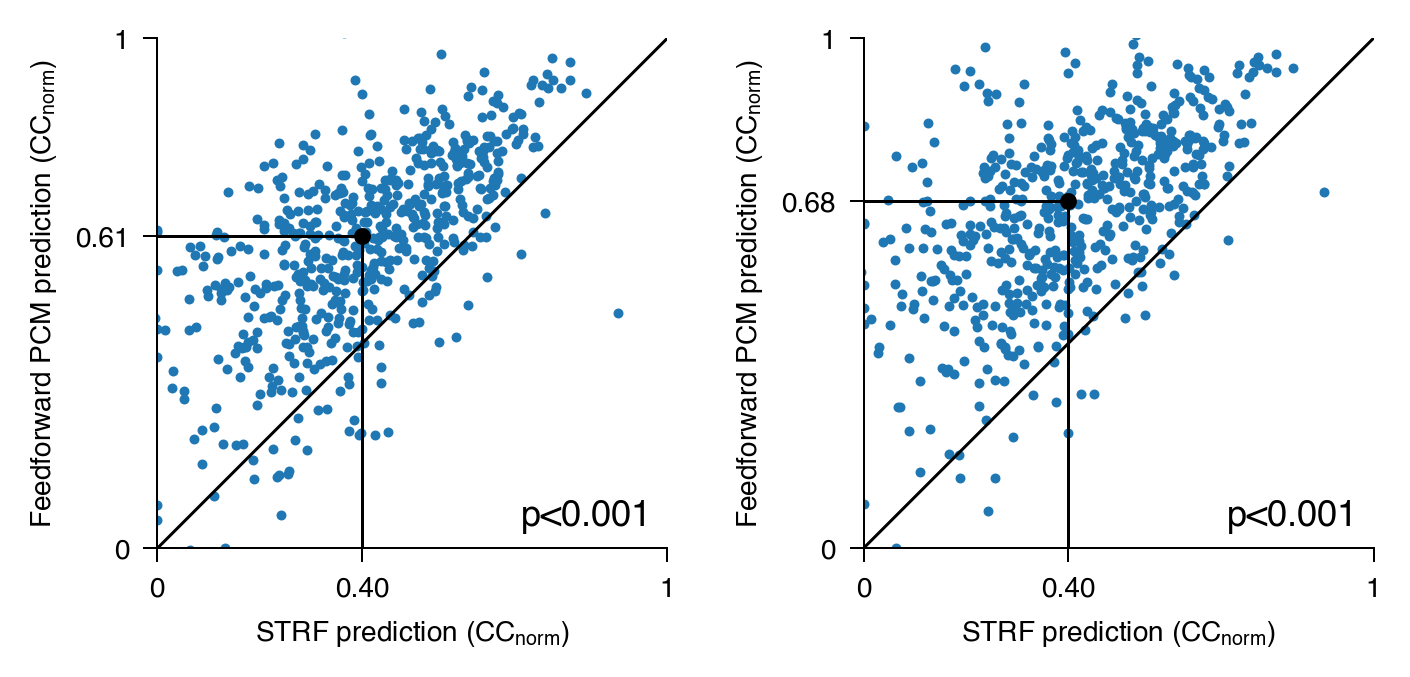

In [9]:
# Feedforward model vs cochleagram (without awake / anaesthetised symbols, just for check)

fig = plt.figure(figsize=(5.8,2.3))
sel = clusters.select_data(brain_area='ac', noiseratio=200, excluded=False)

# feedforward model vs cochleagram
plt.subplot(1,2,1)
regressor_area = 'ic_mgb'
x_data = [coch_kernel_main_ln_cc_norm_test(cl, regressor_area) for cl in sel]
y_data = [a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in sel]
scatter_cc(x_data, y_data, color=BRAIN_AREA_COLORS['ac'],
           central_tendency_lines_full_width=False,
           p_value=True, accept_nans=False)

plt.xlabel('STRF prediction ($CC_{norm}$)')
plt.ylabel('Feedforward PCM prediction ($CC_{norm}$)')

# full model vs cochleagram
plt.subplot(1,2,2)
regressor_area = 'ic_mgb_ac'
x_data = [coch_kernel_main_ln_cc_norm_test(cl, regressor_area) for cl in sel]
y_data = [a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in sel]
scatter_cc(x_data, y_data, color=BRAIN_AREA_COLORS['ac'],
           p_value=True, accept_nans=False)

plt.xlabel('STRF prediction ($CC_{norm}$)')
plt.ylabel('Feedforward PCM prediction ($CC_{norm}$)')

print('n=%d' % len(sel))